In [1]:
!pip install torch --upgrade wandb

In [1]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
import random
import json
import datetime
import time
import wandb

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roanschellingerhout. Use `wandb login --relogin` to force relogin


True

In [3]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
skills = dict(zip(skills.index, skills.values))

In [5]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
certs = dict(zip(certs.index, certs.values))

In [7]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [8]:
licenses = dict(zip(licenses.index, licenses.values))

In [9]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
languages = dict(zip(languages.index, languages.values))

In [11]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,91
84612,49
84731,3773
85437,3819
85627,1560


In [12]:
addresses = dict(zip(addresses.index, addresses.values))

In [13]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [14]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [15]:
df_pred = df_pred.drop(["time_between", "job_order", "source"], axis=1)

In [16]:
# df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()

In [17]:
df_pred.head()

,candidate_id,time_spent,isco_functie_niveau,education,company_name,function_id,isco_code4
0,84556,-0.210459,2.0,0.0,324258,936,208
1,84556,-0.252626,1.0,0.0,324258,809,348
2,84556,-0.085012,2.0,0.0,329244,936,208
3,84556,-0.370694,1.0,0.0,368140,1519,344
4,84556,-0.363314,1.0,0.0,419826,1519,344


In [18]:
career_paths = df_pred.groupby("candidate_id")

In [19]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [20]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 6)

In [21]:
maximum_career_duration = 25

In [22]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:52<00:00, 8867.24it/s]


In [23]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [24]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [25]:
career_paths.head()

candidate_id
84556    [[-0.21045870102048395, 2.0, 0.0, 324258.0, 93...
84612    [[-0.3685852264755267, 1.0, 0.0, 201740.0, 151...
84731    [[-0.35066422025728855, 1.0, 0.0, 353745.0, 15...
85437    [[0.3313881928721292, 1.0, 2.0, 5500.0, 1519.0...
85888    [[-0.2895219637480053, 2.0, 3.0, 423330.0, 795...
dtype: object

In [26]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [27]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [28]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [29]:
del df_pred
del x

In [30]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [31]:
len(to_fill), len(y)

(113724, 113724)

In [32]:
# to_fill = to_fill[:50000]
# y = y[:50000]

In [33]:
def create_loaders(to_fill, idxs, y, split_size=0.8, weight_type=3, batch_size=512):

    # Train test split
    split = split_size

    training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
    test = np.array(list(set(range(len(to_fill))) - set(training)))

    train_indices, val_indices = idxs[training], idxs[test]
    X_train, X_val = to_fill[training], to_fill[test]
    y_train, y_val = y[training].astype(int), y[test].astype(int)

    # Class weights
    counts = (np.bincount(y_train) + 1)
    
    if weight_type == 1:
        labels_weights = 1. / counts
    elif weight_type == 2:
        labels_weights = 1. / np.sqrt(counts)
    elif weight_type == 3:
        labels_weights = 2. / (0.5 * np.sqrt(counts))
    else:
        return NotImplemented
        
    weights = labels_weights[y_train]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create dataloaders
    train_data = TensorDataset(torch.Tensor(train_indices), 
                               torch.Tensor(X_train), 
                               torch.Tensor(y_train).type(torch.LongTensor))

    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

    val_data = TensorDataset(torch.Tensor(val_indices),
                             torch.Tensor(X_val),
                             torch.Tensor(y_val).type(torch.LongTensor))

    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    return trainloader, valloader

In [34]:
class CNN(nn.Module):

    def __init__(self, num_classes, input_size, f_out,
                 kernel_size, pooling_size, dropout,                
                 skills, certs, licenses, languages, 
                 addresses, w2v, candidate_lengths, max_len, 
                 skill_embedding_size=50, certs_embedding_size=20,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=50, 
                 isco4_embedding_size=25, education_embedding_size=3, 
                 isco_level_embedding_size=3, company_embedding_size=50):
        
        super(CNN, self).__init__()
              
        self.num_classes = num_classes
        self.input_size = input_size + 300
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4768, address_embedding_size)       
        
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.source_embedding = nn.Embedding(2, 1)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(6, isco_level_embedding_size)
        
        # -6 --> embedded features get replaced
        N = self.input_size - 5 + skill_embedding_size + certs_embedding_size + \
            license_embedding_size + language_embedding_size + address_embedding_size + \
            function_embedding_size + isco4_embedding_size + company_embedding_size + \
            education_embedding_size + isco_level_embedding_size
        
        # Actual model
        self.conv2d = nn.Conv2d(in_channels=1,
                                out_channels=f_out, 
                                kernel_size=(kernel_size, kernel_size), 
                                stride=1, 
                                padding=(kernel_size // 2))
        
        self.relu = nn.ReLU()
        self.maxpooling = nn.MaxPool3d(kernel_size=(f_out, pooling_size, pooling_size))
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.fc = nn.Linear((N // pooling_size) * (max_len // pooling_size), num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        
        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len        
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])
    
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
                        
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:
                    # 0, 10, 20, 30, 40, 50
                    # duration = 50
                    # ---> 0, 5, 15, 25
                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([torch.Tensor(embed_values[i + to_skip])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
 
    def forward(self, candidate, x):               
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 500).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
        
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
                
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
                        
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
            
            # Reset to max_len
            career_duration = min(career_duration, max_len)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                   
            # Broadcast and add static features
            static_features = torch.stack([batch_features[i]] * career_duration).type(torch.LongTensor).to(device)
            address_emb = torch.stack([batch_addresses[i]] * career_duration).type(torch.LongTensor).to(device)
            
            # Combine w2v, static features, and address
            full_features = torch.cat([w2v_list, static_features, address_emb], dim=1)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, full_features], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, education, company_name, function_id, isco_code = [x[:,:,-5],
                                                                       x[:,:,-4],
                                                                       x[:,:,-3],
                                                                       x[:,:,-2],
                                                                       x[:,:,-1]]
        
        x = x[:,:,:-5].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
                
        isco_level, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                        self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                        self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                        self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                        self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]   
                
        # Add features
        x = torch.cat([x, isco_level, education, company_name, function_id, isco_code, additional_features], dim=2)
        
        x = x.unsqueeze(1)
        
        x = self.conv2d(x)
        x = self.relu(x)
        x = self.maxpooling(x)
                
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        out = self.fc(x)
               
        # softmax
        out = self.softmax(out)
                        
        return out

In [42]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    highest_performance = 0
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            
            career, job = career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs = model(candidate, career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
               
        training_loss /= len(trainloader)
                
        stats = test_loop(valloader, model, criterion)
        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)

        scheduler.step()
        
        if stats[0] > highest_performance:
            torch.save(model.state_dict(), "../models/CNN.pt")
            highest_performance = stats[0]
            
        wandb.log({"test loss": stats[4],
                   "training loss": training_loss,
                   "test accuracy": stats[0] * 100})
        
        print(f"Epoch duration: {int((time.time() - start) // 60)}:{int((time.time() - start) % 60):02d}\n")
        
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            career, job = career.to(device), job.to(device)
            pred = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
#         a = weights[0].cpu().detach().numpy().mean(axis=0)            
#         plt.plot(a, label="average")
#         plt.plot(weights[0][np.random.choice(range(len(weights[0])))].cpu().detach().numpy(), label="random example")
#         plt.xlabel("Career step")
#         plt.ylabel("Attention weight")
#         plt.show()
 
            
    # print("\nValidation:", Counter(np.array(pred.argmax(1).cpu())))
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [43]:
torch.cuda.empty_cache()

In [ ]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 3
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-2, 1e-3, 1e-4][1:2]
f_outs = [48, 64, 128][1:]
kernel_sizes = [1, 3, 5]
pooling_sizes = [1, 3]
batch_sizes = [128, 512, 1024]
dropout_probs = [0.0, 0.25]

skill_embedding_size=100
certs_embedding_size=50
license_embedding_size=10
language_embedding_size=15
address_embedding_size=25
function_embedding_size=250
isco4_embedding_size=150
education_embedding_size=10
isco_level_embedding_size=10
company_embedding_size=300
w2v_embedding_size = 300

try:            
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for f_out in f_outs:
                for kernel_size in kernel_sizes:
                    for pooling_size in pooling_sizes:
                        for dropout in dropout_probs:

                            cnn = CNN(num_classes=num_classes,
                                      input_size=num_features,
                                      f_out=f_out,
                                      pooling_size=pooling_size,
                                      kernel_size=kernel_size,
                                      dropout=dropout,
                                      skills=skills, 
                                      certs=certs,
                                      licenses=licenses,
                                      languages=languages,
                                      addresses=addresses,
                                      w2v=w2v,
                                      skill_embedding_size=skill_embedding_size,
                                      certs_embedding_size=certs_embedding_size,
                                      license_embedding_size=license_embedding_size,
                                      language_embedding_size=language_embedding_size,
                                      address_embedding_size=address_embedding_size,
                                      function_embedding_size=function_embedding_size,
                                      isco4_embedding_size=isco4_embedding_size,
                                      education_embedding_size=education_embedding_size,
                                      isco_level_embedding_size=isco_level_embedding_size,
                                      company_embedding_size=company_embedding_size,
                                      candidate_lengths=candidate_lens,
                                      max_len=max_len)

                            cnn = cnn.to(device)

                            optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
                            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

                            print(f"Current iteration {current}/{len(learning_rates) * len(f_outs) * len(kernel_sizes) * len(pooling_sizes) * len(dropout_probs) * len(batch_sizes)}")
                            print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", cnn, "\n")

                            wandb.init(project="CNN", entity="roanschellingerhout", config= {"learning_rate": learning_rate,
                                                                                             "epochs": 3,
                                                                                             "batch_size": batch_size,
                                                                                             "f_outs": f_out,
                                                                                             "kernel_size": kernel_size,
                                                                                             "pooling_size": pooling_size,
                                                                                             "dropout": dropout})


                            trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                                                    weight_type=3, batch_size=batch_size)

                            # Store results of current configuration
                            outcome = train_loop(cnn, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                            outcome["lr"] = [learning_rate] * num_epochs
                            outcome["Batch size"] = [batch_size] * num_epochs
                            outcome["Number of filters"] = [f_out] * num_epochs
                            outcome["Kernel size"] = [kernel_size] * num_epochs
                            outcome["Pooling size"] = [pooling_size] * num_epochs
                            outcome["Dropout"] = [dropout] * num_epochs


                            full_results.append(outcome)

                            with open("../results/CNN.json", "w") as current_stats:
                                json.dump(full_results, current_stats)


                            current += 1
except KeyboardInterrupt:
    pass

Current iteration 0/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=False)
  (license_embedding): Linear(in_features=8, out_features=10, bias=False)
  (language_embedding): Linear(in_features=23, out_features=15, bias=False)
  (address_embedding): Embedding(4768, 25)
  (function_embedding): Embedding(2992, 250)
  (isco_code_embedding): Embedding(355, 150)
  (company_embedding): Embedding(441153, 300)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 10)
  (isco_level_embedding): Embedding(6, 10)
  (conv2d): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (maxpooling): MaxPool3d(kernel_size=(64, 1, 1), stride=(64, 1, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=30525, out_features=355, bias=True)
  (softmax): LogSoftmax(dim=-1)
) 



-------------------------------------------------------------------------------
Epoch starting at: 20:20:26
Epoch: 1, batch: 711/711, loss: 12.706347
Test Error:
Acc@1: 12.22%, Acc@5: 30.84%, Acc@10: 37.29%, Acc@20: 45.46% Avg loss: 9.902354
Epoch duration: 4:35

-------------------------------------------------------------------------------
Epoch starting at: 20:25:01
Epoch: 2, batch: 711/711, loss: 6.398444
Test Error:
Acc@1: 13.73%, Acc@5: 36.32%, Acc@10: 47.97%, Acc@20: 60.35% Avg loss: 7.084392
Epoch duration: 4:36

-------------------------------------------------------------------------------
Epoch starting at: 20:29:37
Epoch: 3, batch: 711/711, loss: 4.335701
Test Error:
Acc@1: 12.39%, Acc@5: 33.54%, Acc@10: 43.49%, Acc@20: 54.42% Avg loss: 6.060896
Epoch duration: 4:28

Current iteration 1/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bia

test accuracy,▁█▂
test loss,█▃▁
training loss,█▁▁
test accuracy,12.39393
test loss,6.0609
training loss,7.87863


-------------------------------------------------------------------------------
Epoch starting at: 20:34:18
Epoch: 1, batch: 711/711, loss: 17.446191
Test Error:
Acc@1: 2.08%, Acc@5: 12.31%, Acc@10: 21.53%, Acc@20: 33.45% Avg loss: 9.581107
Epoch duration: 4:35

-------------------------------------------------------------------------------
Epoch starting at: 20:38:54
Epoch: 2, batch: 711/711, loss: 21.51837
Test Error:
Acc@1: 6.41%, Acc@5: 23.66%, Acc@10: 33.85%, Acc@20: 44.64% Avg loss: 10.488424
Epoch duration: 4:34

-------------------------------------------------------------------------------
Epoch starting at: 20:43:28
Epoch: 3, batch: 711/711, loss: 7.830098
Test Error:
Acc@1: 13.61%, Acc@5: 33.19%, Acc@10: 43.67%, Acc@20: 55.68% Avg loss: 7.678148
Epoch duration: 4:34

Current iteration 2/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias

test accuracy,▁▄█
test loss,▆█▁
training loss,█▁▁
test accuracy,13.60739
test loss,7.67815
training loss,11.05992


-------------------------------------------------------------------------------
Epoch starting at: 20:48:16
Epoch: 1, batch: 711/711, loss: 4.79701
Test Error:
Acc@1: 12.85%, Acc@5: 33.23%, Acc@10: 51.19%, Acc@20: 62.88% Avg loss: 4.338921
Epoch duration: 4:25

-------------------------------------------------------------------------------
Epoch starting at: 20:52:41
Epoch: 2, batch: 711/711, loss: 3.74453
Test Error:
Acc@1: 14.64%, Acc@5: 44.80%, Acc@10: 56.84%, Acc@20: 68.23% Avg loss: 4.211503
Epoch duration: 4:23

-------------------------------------------------------------------------------
Epoch starting at: 20:57:05
Epoch: 3, batch: 711/711, loss: 3.82318
Test Error:
Acc@1: 13.82%, Acc@5: 42.16%, Acc@10: 56.87%, Acc@20: 69.97% Avg loss: 4.250142
Epoch duration: 4:17

Current iteration 3/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=Fa

test accuracy,▁█▅
test loss,█▁▃
training loss,█▃▁
test accuracy,13.82282
test loss,4.25014
training loss,3.79027


-------------------------------------------------------------------------------
Epoch starting at: 21:01:35
Epoch: 1, batch: 711/711, loss: 4.86814
Test Error:
Acc@1: 11.95%, Acc@5: 32.44%, Acc@10: 44.45%, Acc@20: 58.01% Avg loss: 4.456707
Epoch duration: 4:27

-------------------------------------------------------------------------------
Epoch starting at: 21:06:02
Epoch: 2, batch: 711/711, loss: 4.66144
Test Error:
Acc@1: 7.60%, Acc@5: 32.27%, Acc@10: 47.91%, Acc@20: 63.28% Avg loss: 4.441047
Epoch duration: 4:18

-------------------------------------------------------------------------------
Epoch starting at: 21:10:20
Epoch: 3, batch: 711/711, loss: 3.59868
Test Error:
Acc@1: 13.56%, Acc@5: 43.74%, Acc@10: 56.14%, Acc@20: 69.15% Avg loss: 4.212950
Epoch duration: 4:25

Current iteration 4/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=Fal

test accuracy,▆▁█
test loss,██▁
training loss,█▄▁
test accuracy,13.56342
test loss,4.21295
training loss,4.17076


-------------------------------------------------------------------------------
Epoch starting at: 21:14:58
Epoch: 1, batch: 711/711, loss: 3.38482
Test Error:
Acc@1: 16.42%, Acc@5: 40.60%, Acc@10: 53.53%, Acc@20: 66.93% Avg loss: 4.226785
Epoch duration: 4:28

-------------------------------------------------------------------------------
Epoch starting at: 21:19:27
Epoch: 2, batch: 711/711, loss: 1.95965
Test Error:
Acc@1: 20.48%, Acc@5: 48.26%, Acc@10: 61.12%, Acc@20: 73.26% Avg loss: 4.197689
Epoch duration: 4:27

-------------------------------------------------------------------------------
Epoch starting at: 21:23:55
Epoch: 3, batch: 711/711, loss: 1.35897
Test Error:
Acc@1: 17.25%, Acc@5: 43.41%, Acc@10: 58.49%, Acc@20: 72.98% Avg loss: 4.597393
Epoch duration: 4:21

Current iteration 5/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=Fa

test accuracy,▁█▂
test loss,▂▁█
training loss,█▂▁
test accuracy,17.24775
test loss,4.59739
training loss,1.66846


-------------------------------------------------------------------------------
Epoch starting at: 21:28:30
Epoch: 1, batch: 711/711, loss: 3.045997
Test Error:
Acc@1: 19.20%, Acc@5: 44.48%, Acc@10: 57.32%, Acc@20: 70.52% Avg loss: 3.946631
Epoch duration: 4:28

-------------------------------------------------------------------------------
Epoch starting at: 21:32:59
Epoch: 2, batch: 711/711, loss: 2.07272
Test Error:
Acc@1: 20.55%, Acc@5: 46.65%, Acc@10: 59.35%, Acc@20: 72.38% Avg loss: 4.071800
Epoch duration: 4:28

-------------------------------------------------------------------------------
Epoch starting at: 21:37:27
Epoch: 3, batch: 711/711, loss: 1.53702
Test Error:
Acc@1: 18.38%, Acc@5: 43.78%, Acc@10: 57.03%, Acc@20: 71.05% Avg loss: 4.423718
Epoch duration: 4:22

Current iteration 6/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=F

test accuracy,▄█▁
test loss,▁▃█
training loss,█▂▁
test accuracy,18.37767
test loss,4.42372
training loss,1.92222


-------------------------------------------------------------------------------
Epoch starting at: 21:42:02
Epoch: 1, batch: 711/711, loss: 4.14595
Test Error:
Acc@1: 16.20%, Acc@5: 42.76%, Acc@10: 56.60%, Acc@20: 70.48% Avg loss: 4.080543
Epoch duration: 4:18

-------------------------------------------------------------------------------
Epoch starting at: 21:46:21
Epoch: 2, batch: 711/711, loss: 2.55559
Test Error:
Acc@1: 13.86%, Acc@5: 41.11%, Acc@10: 56.08%, Acc@20: 70.83% Avg loss: 4.101431
Epoch duration: 4:12

-------------------------------------------------------------------------------
Epoch starting at: 21:50:33
Epoch: 3, batch: 711/711, loss: 1.88989
Test Error:
Acc@1: 14.74%, Acc@5: 41.62%, Acc@10: 56.83%, Acc@20: 71.67% Avg loss: 4.339237
Epoch duration: 4:12

Current iteration 7/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=Fa

test accuracy,█▁▄
test loss,▁▂█
training loss,█▃▁
test accuracy,14.7373
test loss,4.33924
training loss,2.42524


-------------------------------------------------------------------------------
Epoch starting at: 21:54:58
Epoch: 1, batch: 711/711, loss: 4.36824
Test Error:
Acc@1: 14.28%, Acc@5: 40.67%, Acc@10: 54.79%, Acc@20: 68.76% Avg loss: 4.109494
Epoch duration: 4:20

-------------------------------------------------------------------------------
Epoch starting at: 21:59:18
Epoch: 2, batch: 711/711, loss: 3.34366
Test Error:
Acc@1: 15.07%, Acc@5: 40.31%, Acc@10: 53.96%, Acc@20: 68.39% Avg loss: 4.087813
Epoch duration: 4:18

-------------------------------------------------------------------------------
Epoch starting at: 22:03:37
Epoch: 3, batch: 711/711, loss: 3.02225
Test Error:
Acc@1: 14.28%, Acc@5: 40.12%, Acc@10: 55.31%, Acc@20: 70.13% Avg loss: 4.205796
Epoch duration: 4:13

Current iteration 8/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=Fa

test accuracy,▁█▁
test loss,▂▁█
training loss,█▄▁
test accuracy,14.28446
test loss,4.2058
training loss,2.92071


-------------------------------------------------------------------------------
Epoch starting at: 22:08:04
Epoch: 1, batch: 711/711, loss: 2.85060
Test Error:
Acc@1: 20.79%, Acc@5: 47.31%, Acc@10: 60.05%, Acc@20: 72.13% Avg loss: 3.900754
Epoch duration: 5:15

-------------------------------------------------------------------------------
Epoch starting at: 22:13:19
Epoch: 2, batch: 711/711, loss: 2.00576
Test Error:
Acc@1: 20.75%, Acc@5: 47.23%, Acc@10: 59.93%, Acc@20: 72.49% Avg loss: 4.241442
Epoch duration: 5:07

-------------------------------------------------------------------------------
Epoch starting at: 22:18:27
Epoch: 3, batch: 711/711, loss: 1.47308
Test Error:
Acc@1: 17.72%, Acc@5: 44.05%, Acc@10: 57.96%, Acc@20: 71.92% Avg loss: 4.804941
Epoch duration: 5:06

Current iteration 9/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=Fa

test accuracy,██▁
test loss,▁▄█
training loss,█▂▁
test accuracy,17.71818
test loss,4.80494
training loss,1.61521


-------------------------------------------------------------------------------
Epoch starting at: 22:23:46
Epoch: 1, batch: 711/711, loss: 3.25964
Test Error:
Acc@1: 20.32%, Acc@5: 46.39%, Acc@10: 59.59%, Acc@20: 72.56% Avg loss: 3.891949
Epoch duration: 5:14

-------------------------------------------------------------------------------
Epoch starting at: 22:29:01
Epoch: 2, batch: 711/711, loss: 2.07495
Test Error:
Acc@1: 17.14%, Acc@5: 43.24%, Acc@10: 56.90%, Acc@20: 71.28% Avg loss: 4.235981
Epoch duration: 5:07

-------------------------------------------------------------------------------
Epoch starting at: 22:34:08
Epoch: 3, batch: 711/711, loss: 1.29287
Test Error:
Acc@1: 19.22%, Acc@5: 44.53%, Acc@10: 58.56%, Acc@20: 72.74% Avg loss: 4.463306
Epoch duration: 5:07

Current iteration 10/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=F

test accuracy,█▁▆
test loss,▁▅█
training loss,█▂▁
test accuracy,19.22181
test loss,4.46331
training loss,1.83846


-------------------------------------------------------------------------------
Epoch starting at: 22:39:28
Epoch: 1, batch: 711/711, loss: 3.93381
Test Error:
Acc@1: 17.16%, Acc@5: 45.25%, Acc@10: 58.70%, Acc@20: 71.15% Avg loss: 3.981510
Epoch duration: 5:04

-------------------------------------------------------------------------------
Epoch starting at: 22:44:33
Epoch: 2, batch: 711/711, loss: 2.64442
Test Error:
Acc@1: 16.59%, Acc@5: 44.03%, Acc@10: 57.89%, Acc@20: 72.08% Avg loss: 4.046548
Epoch duration: 4:59

-------------------------------------------------------------------------------
Epoch starting at: 22:49:32
Epoch: 3, batch: 711/711, loss: 1.80626
Test Error:
Acc@1: 15.17%, Acc@5: 43.00%, Acc@10: 57.85%, Acc@20: 72.57% Avg loss: 4.266829
Epoch duration: 4:58

Current iteration 11/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=F

test accuracy,█▆▁
test loss,▁▃█
training loss,█▃▁
test accuracy,15.16817
test loss,4.26683
training loss,2.26557


-------------------------------------------------------------------------------
Epoch starting at: 22:54:42
Epoch: 1, batch: 711/711, loss: 4.41881
Test Error:
Acc@1: 16.76%, Acc@5: 44.03%, Acc@10: 57.38%, Acc@20: 70.66% Avg loss: 4.047566
Epoch duration: 5:04

-------------------------------------------------------------------------------
Epoch starting at: 22:59:47
Epoch: 2, batch: 711/711, loss: 3.07810
Test Error:
Acc@1: 15.96%, Acc@5: 41.49%, Acc@10: 55.56%, Acc@20: 69.80% Avg loss: 4.004641
Epoch duration: 4:57

-------------------------------------------------------------------------------
Epoch starting at: 23:04:45
Epoch: 3, batch: 711/711, loss: 2.88554
Test Error:
Acc@1: 16.21%, Acc@5: 42.48%, Acc@10: 56.17%, Acc@20: 70.34% Avg loss: 4.107081
Epoch duration: 4:57

Current iteration 12/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=F

test accuracy,█▁▃
test loss,▄▁█
training loss,█▄▁
test accuracy,16.20576
test loss,4.10708
training loss,2.85047


-------------------------------------------------------------------------------
Epoch starting at: 23:09:55
Epoch: 1, batch: 711/711, loss: 11.089479
Test Error:
Acc@1: 2.33%, Acc@5: 8.06%, Acc@10: 12.97%, Acc@20: 20.38% Avg loss: 10.666689
Epoch duration: 7:56

-------------------------------------------------------------------------------
Epoch starting at: 23:17:52
Epoch: 2, batch: 711/711, loss: 9.577091
Test Error:
Acc@1: 14.84%, Acc@5: 28.36%, Acc@10: 36.76%, Acc@20: 48.14% Avg loss: 9.623002
Epoch duration: 7:56

-------------------------------------------------------------------------------
Epoch starting at: 23:25:48
Epoch: 3, batch: 711/711, loss: 6.615851
Test Error:
Acc@1: 10.25%, Acc@5: 32.07%, Acc@10: 43.05%, Acc@20: 53.54% Avg loss: 7.646016
Epoch duration: 7:49

Current iteration 13/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bia

test accuracy,▁█▅
test loss,█▆▁
training loss,█▁▁
test accuracy,10.2528
test loss,7.64602
training loss,8.00652


-------------------------------------------------------------------------------
Epoch starting at: 23:33:50
Epoch: 1, batch: 711/711, loss: 13.497017
Test Error:
Acc@1: 6.24%, Acc@5: 28.38%, Acc@10: 36.80%, Acc@20: 46.01% Avg loss: 9.096997
Epoch duration: 7:57

-------------------------------------------------------------------------------
Epoch starting at: 23:41:47
Epoch: 2, batch: 711/711, loss: 12.89755
Test Error:
Acc@1: 6.13%, Acc@5: 18.29%, Acc@10: 28.67%, Acc@20: 39.71% Avg loss: 8.603675
Epoch duration: 7:50

-------------------------------------------------------------------------------
Epoch starting at: 23:49:38
Epoch: 3, batch: 711/711, loss: 5.325776
Test Error:
Acc@1: 6.89%, Acc@5: 19.23%, Acc@10: 29.73%, Acc@20: 43.98% Avg loss: 7.400654
Epoch duration: 7:56

Current iteration 14/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=

test accuracy,▂▁█
test loss,█▆▁
training loss,█▂▁
test accuracy,6.89382
test loss,7.40065
training loss,8.62142


-------------------------------------------------------------------------------
Epoch starting at: 23:57:47
Epoch: 1, batch: 711/711, loss: 5.22079
Test Error:
Acc@1: 8.56%, Acc@5: 33.05%, Acc@10: 42.59%, Acc@20: 55.95% Avg loss: 4.552304
Epoch duration: 7:45

-------------------------------------------------------------------------------
Epoch starting at: 00:05:32
Epoch: 2, batch: 711/711, loss: 4.25148
Test Error:
Acc@1: 9.16%, Acc@5: 39.58%, Acc@10: 52.53%, Acc@20: 63.68% Avg loss: 4.348093
Epoch duration: 7:45

-------------------------------------------------------------------------------
Epoch starting at: 00:13:18
Epoch: 3, batch: 711/711, loss: 3.72682
Test Error:
Acc@1: 13.63%, Acc@5: 42.51%, Acc@10: 55.03%, Acc@20: 68.81% Avg loss: 4.293842
Epoch duration: 7:45

Current iteration 15/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=Fal

test accuracy,▁▂█
test loss,█▂▁
training loss,█▄▁
test accuracy,13.63377
test loss,4.29384
training loss,3.95267


-------------------------------------------------------------------------------
Epoch starting at: 00:21:15
Epoch: 1, batch: 711/711, loss: 5.48364
Test Error:
Acc@1: 12.81%, Acc@5: 33.20%, Acc@10: 43.39%, Acc@20: 53.82% Avg loss: 4.486230
Epoch duration: 7:45

-------------------------------------------------------------------------------
Epoch starting at: 00:29:00
Epoch: 2, batch: 711/711, loss: 4.94521
Test Error:
Acc@1: 10.57%, Acc@5: 35.41%, Acc@10: 47.68%, Acc@20: 61.01% Avg loss: 4.315133
Epoch duration: 7:38

-------------------------------------------------------------------------------
Epoch starting at: 00:36:39
Epoch: 3, batch: 711/711, loss: 3.87722
Test Error:
Acc@1: 11.10%, Acc@5: 39.85%, Acc@10: 52.34%, Acc@20: 66.02% Avg loss: 4.325643
Epoch duration: 7:38

Current iteration 16/72
- Initial learning rate: 0.001
- Model: 

 CNN(
  (skill_embedding): Linear(in_features=317, out_features=100, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=50, bias=F

test accuracy,█▁▃
test loss,█▁▁
training loss,█▄▁
test accuracy,11.09694
test loss,4.32564
training loss,4.29881


-------------------------------------------------------------------------------
Epoch starting at: 00:44:30
Epoch: 1, batch: 711/711, loss: 3.510852
Test Error:
Acc@1: 14.73%, Acc@5: 39.13%, Acc@10: 53.09%, Acc@20: 67.44% Avg loss: 4.173497
Epoch duration: 7:51

-------------------------------------------------------------------------------
Epoch starting at: 00:52:21
Epoch: 2, batch: 711/711, loss: 2.14522
Test Error:
Acc@1: 19.26%, Acc@5: 45.18%, Acc@10: 58.74%, Acc@20: 72.26% Avg loss: 4.175368
Epoch duration: 7:50

-------------------------------------------------------------------------------
Epoch starting at: 01:00:12


In [46]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Batch size", "Number of filters", "Kernel size", "Pooling size", "Dropout", "Epoch"])

In [47]:
total

Acc@1  \
lr    Batch size Number of filters Kernel size Pooling size Dropout Epoch             
0.001 128        64                1           1            0.00    1      0.122181   
                                                                    2      0.137349   
                                                                    3      0.123939   
                                                            0.25    1      0.020796   
                                                                    2      0.064102   
...                                                                             ...   
                 128               5           3            0.00    2      0.156518   
                                                                    3      0.153572   
                                                            0.25    1      0.167773   
                                                                    2      0.140558   
                                                                    3      0.134007   

                                                                              Acc@5  \
lr    Batch size Number of filters Kernel size Pooling size Dropout Epoch             
0.001 128        64                1           1            0.00    1      0.308419   
                                                                    2      0.363201   
                                                                    3      0.335414   
                                                            0.25    1      0.123104   
                                                                    2      0.236579   
...                                                                             ...   
                 128               5           3            0.00    2      0.421719   
                                                                    3      0.413761   
                                                            0.25    1      0.440536   
                                                                    2      0.413366   
                                                                    3      0.390855   

                                                                             Acc@10  \
lr    Batch size Number of filters Kernel size Pooling size Dropout Epoch             
0.001 128        64                1           1            0.00    1      0.372917   
                                                                    2      0.479710   
                                                                    3      0.434865   
                                                            0.25    1      0.215300   
                                                                    2      0.338492   
...                                                                             ...   
                 128               5           3            0.00    2      0.568652   
                                                                    3      0.563464   
                                                            0.25    1      0.575379   
                                                                    2      0.557309   
                                                                    3      0.534359   

                                                                             Acc@20  \
lr    Batch size Number of filters Kernel size Pooling size Dropout Epoch             
0.001 128        64                1           1            0.00    1      0.454561   
                                                                    2      0.603517   
                                                                    3      0.544164   
                                                            0.25    1      0.334491   
                                                                    2      0.446428   
...                                                                      

In [48]:
total.to_csv("../results/CNN-results_2.csv")

Batch accuracy: 0.1328125
Previous-job baseline accuracy: 0.0
Fraction of previous job predictions: 0.130859375


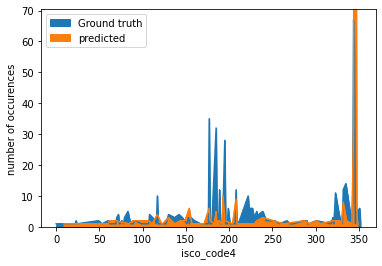

In [52]:
with torch.no_grad():
    for candidate, career, job in valloader:
        career, job = career.to(device), job.to(device)
        pred = cnn(candidate, career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())        
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        previous_job = torch.Tensor(career_paths.loc[candidate.cpu()].apply(lambda x: x[-2][-1]).values).to(device)
        print("Previous-job baseline accuracy:", (job == previous_job).cpu().numpy().mean())
        print("Fraction of previous job predictions:", (pred.argmax(1) == previous_job).cpu().numpy().mean())
        
        plt.show()        
        break